# House prices

Kairos (April 2018)


## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

## Notice
Run at least once '0.House_prices_preparing_dataset' before run this snippet.

## Synthetic Features and Outliers
This notebook continues the linear regression model started in the previous exercise. In this exercise, we'll try new features and study the effect of outliers in the input data.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [176]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

## 2. Load our data set
Next, we'll load our data set and show information about it.

In [177]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


## 3. Random the data
We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we scale "SalePrice" to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [178]:
housing_dataframe = housing_dataframe.reindex(
    np.random.permutation(housing_dataframe.index))
housing_dataframe["SalePrice"] /= 1000.0
housing_dataframe

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
968,973,120,7892,6,5,1979,1979,0.0,0,0,...,1,0,2,0,0,1,0,0,0,0
770,774,20,10150,5,5,1958,1958,1.0,456,0,...,1,0,0,0,2,1,0,0,2,0
1086,1093,50,8400,6,5,1925,1950,0.0,423,0,...,0,0,3,0,0,1,0,0,0,0
779,783,20,16285,7,5,2001,2002,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,238,60,9453,7,7,1993,2003,0.0,402,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,1172,20,9120,6,6,1958,1958,0.0,662,0,...,1,0,0,0,0,1,0,0,0,0
1028,1035,30,6305,5,7,1938,1950,0.0,0,0,...,0,0,0,0,0,3,0,0,0,0
944,949,60,14006,7,5,2002,2002,144.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1435,1445,20,8500,7,5,2004,2004,106.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6. Examine the data
It's a good idea to get to know your data a little bit before you work with it.
We'll print out a quick summary of a few useful statistics on each column.
This will include things like mean, standard deviation, max, min, and various quantiles.

In [179]:
housing_dataframe.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,...,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0
mean,729.4,56.9,10507.8,6.1,5.6,1971.1,1984.8,103.8,442.3,46.8,...,0.7,0.0,0.9,0.1,0.2,0.7,0.2,0.1,0.2,0.3
std,421.7,42.4,9993.0,1.4,1.1,30.2,20.7,181.1,455.4,161.8,...,0.8,0.3,1.0,0.2,0.5,0.7,0.7,0.4,0.8,0.9
min,1.0,20.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,364.5,20.0,7537.5,5.0,5.0,1954.0,1966.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,729.0,50.0,9477.0,6.0,5.0,1972.0,1993.0,0.0,381.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,1094.5,70.0,11600.0,7.0,6.0,2000.0,2004.0,166.0,707.0,0.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,1460.0,190.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,1474.0,...,5.0,5.0,4.0,1.0,4.0,3.0,6.0,2.0,8.0,5.0


## 7. Build the first model
In this exercise, we'll be trying to predict "SalePrice". It will be our label (sometimes also called a target). We'll use "TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)" as our input feature.

To train our model, we'll use the LinearRegressor interface provided by the TensorFlow contrib.learn library. This library takes care of a lot of the plumbing, and exposes a convenient way to interact with data, training, and evaluation.

First, we define the input feature, the target, and create the LinearRegressor object.

The GradientDescentOptimizer implements Mini-Batch Stochastic Gradient Descent (SGD), where the size of the mini-batch is given by the batch_size parameter. Note the learning_rate parameter to the optimizer: it controls the size of the gradient step. We also include a value for gradient_clip_norm for safety. This makes sure that gradients are never too huge, which helps avoid pathological cases in gradient descent.

In [180]:
my_feature = housing_dataframe[["TotRmsAbvGrd"]]
targets = housing_dataframe["SalePrice"]

training_input_fn = learn_io.pandas_input_fn(
    x=my_feature, y=targets, num_epochs=None, batch_size=1)

feature_columns = [tf.contrib.layers.real_valued_column("TotRmsAbvGrd", dimension=1)]

linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001),
    gradient_clip_norm=5.0,
)

Calling fit() on the feature column and targets will train the model.

In [181]:
_ = linear_regressor.fit(
    input_fn=training_input_fn,
    steps=100
)

Let's make predictions on that training data, to see how well we fit the training data.

In [182]:
prediction_input_fn = learn_io.pandas_input_fn(
    x=my_feature, y=targets, num_epochs=1, shuffle=False)

predictions = list(linear_regressor.predict(input_fn=prediction_input_fn))

mean_squared_error = metrics.mean_squared_error(predictions, targets)
print "Mean Squared Error (on training data): %0.3f" % mean_squared_error
print "Root Mean Squared Error (on training data): %0.3f" % math.sqrt(mean_squared_error)

Mean Squared Error (on training data): 38898.563
Root Mean Squared Error (on training data): 197.227


In [183]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_column = housing_dataframe[[my_feature]]
  my_label = "SalePrice"
  targets = housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.contrib.layers.real_valued_column(my_feature, dimension=1)]
  
  # Create input functions
  training_input_fn = learn_io.pandas_input_fn(
    x=my_feature_column, y=targets, num_epochs=None, batch_size=batch_size)
  prediction_input_fn = learn_io.pandas_input_fn(
    x=my_feature_column, y=targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = list(linear_regressor.predict(
        input_fn=prediction_input_fn))
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error
  return calibration_data

## 8. Try a synthetic feature.
Both the "1stFlrSF" and "2ndFlrSF" features count totals for a given house.

We can create a synthetic feature that's a ratio of our two source features.

Create a feature called "totalFlrsSF", and use that as an input in the model code cell below.

What is the best performance you can get with this single feature? (The better the performance, the better your regression line should fit the data and the lower the final RMSE should be.)

Training model...
RMSE (on training data):
  period 00 : 170.64
  period 01 : 144.51
  period 02 : 119.20
  period 03 : 95.35
  period 04 : 76.58
  period 05 : 61.43
  period 06 : 56.55
  period 07 : 56.72
  period 08 : 55.79
  period 09 : 55.56
Model training finished.


,predictions,targets
count,1451.0,1451.0
mean,175.0,180.6
std,60.5,79.3
min,38.7,34.9
25%,130.1,129.9
50%,169.1,162.5
75%,205.8,214.0
max,654.5,755.0


Final RMSE (on training data): 55.56


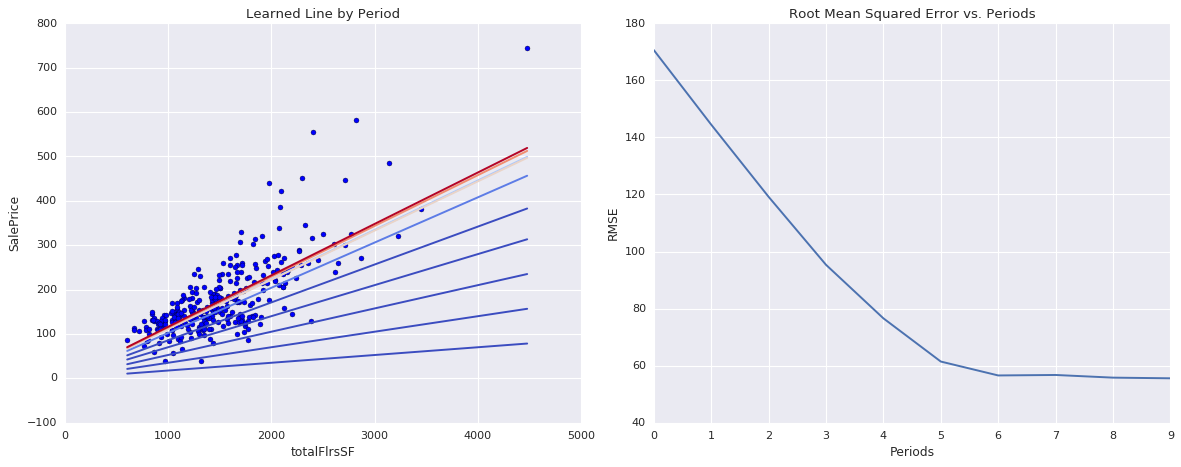

In [184]:
housing_dataframe["totalFlrsSF"] = (
    housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"])

calibration_data = train_model(
    learning_rate=0.0001,
    steps=350,
    batch_size=5,
    input_feature="totalFlrsSF")

## 9. Identify outliers
The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the ones that deviate from the line. We notice that they are relatively few in number.

Plotting a histogram of "totalFlrsSF" reveals that we have a few outliers in our input data.

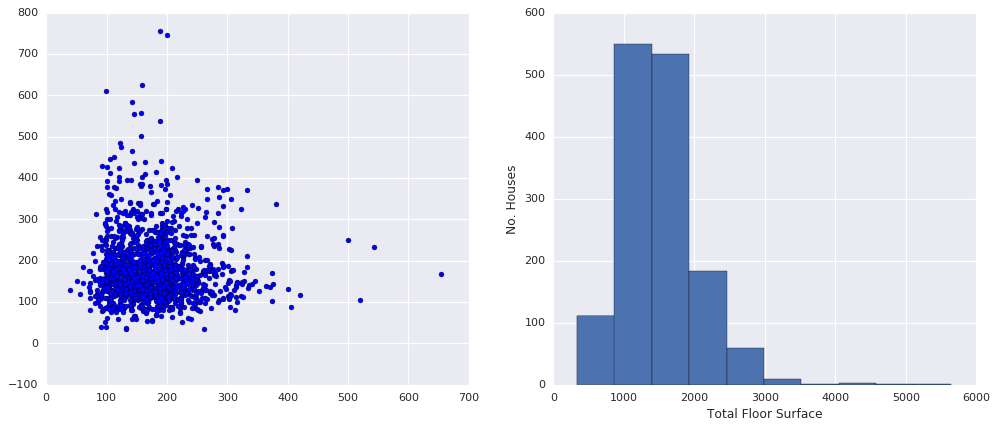

In [185]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.subplot(1, 2, 2)
plt.ylabel('No. Houses')
plt.xlabel('Total Floor Surface')
_ = housing_dataframe["totalFlrsSF"].hist()

## 10. Clip outliers
See if you can improve model fit further by setting outlier values of totalFlrsSF to some sane minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas Series:

clipped_feature = my_feature_column["my_feature_name"].apply(lambda x: max(x, 0))
The above clipped_feature will have no values less than 0.

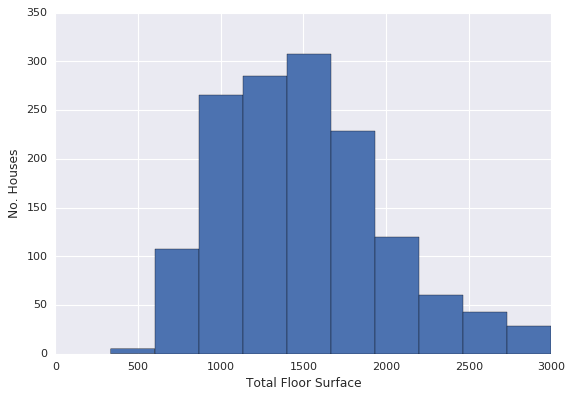

In [186]:
housing_dataframe["totalFlrsSF"] = (
    housing_dataframe["totalFlrsSF"]).apply(lambda x: min(x, 3000))
plt.ylabel('No. Houses')
plt.xlabel('Total Floor Surface')
_ = housing_dataframe["totalFlrsSF"].hist()

To verify that clipping worked, let's train again and print the calibration data once more.

Training model...
RMSE (on training data):
  period 00 : 170.88
  period 01 : 144.97
  period 02 : 119.84
  period 03 : 96.10
  period 04 : 75.08
  period 05 : 62.49
  period 06 : 58.83
  period 07 : 56.28
  period 08 : 55.53
  period 09 : 55.66
Model training finished.


,predictions,targets
count,1451.0,1451.0
mean,171.2,180.6
std,56.0,79.3
min,38.1,34.9
25%,127.9,129.9
50%,166.2,162.5
75%,202.2,214.0
max,342.0,755.0


Final RMSE (on training data): 55.66


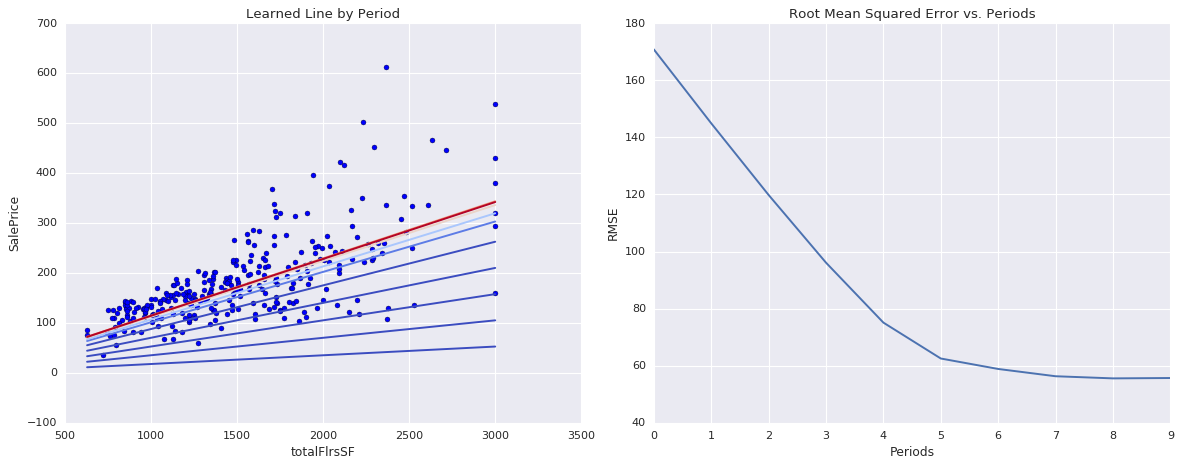

In [187]:
calibration_data = train_model(
    learning_rate=0.0001,
    steps=350,
    batch_size=5,
    input_feature="totalFlrsSF")

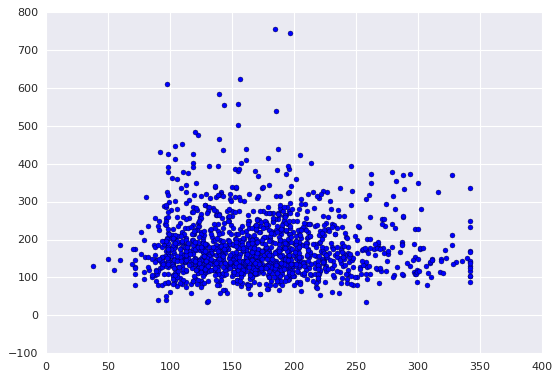

In [188]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])